<a href="https://colab.research.google.com/github/MauricioUhlig/trabalhos_redes_neurais/blob/main/Backpropagation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.utils.validation import check_X_y, check_array, check_is_fitted
from sklearn.metrics import accuracy_score
from sklearn.neural_network import MLPClassifier
from sklearn.datasets import make_classification, make_blobs
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [2]:
from scipy.special import expit
from abc import ABC, abstractmethod

class ActivationFunction(ABC):
  @abstractmethod
  def foward(self, a):
    pass
  @abstractmethod
  def backward(self, a):
    pass

class Tanh(ActivationFunction):
  def foward(self, a):
    return expit(a)*2-1
  def backward(self, a):
    return (1 - np.square(self.foward(a)))

class Sigmoid(ActivationFunction):
  def foward(self, a):
    return expit(a)
  def backward(self, a):
    return self.foward(a)*(1-self.foward(a))

In [3]:
class MLP(BaseEstimator, ClassifierMixin):
    def __init__(self, hidden_layer_sizes=[10], activation='relu',
                 learning_rate=0.01, max_iter=200, random_state=None):
        self.hidden_layer_sizes = hidden_layer_sizes
        self.activation = activation
        self.learning_rate = learning_rate
        self.max_iter = max_iter
        self.random_state = random_state

    def _initialize_weights(self, X, y):
        np.random.seed(self.random_state)
        input_size = X.shape[1]
        output_size = len(np.unique(y))

        # Inicializa pesos e bias para todas as camadas
        layer_sizes = [input_size] + list(self.hidden_layer_sizes) + [output_size]
        self.weights_ = []
        self.biases_ = []

        for i in range(len(layer_sizes)-1):
            limit = np.sqrt(6 / (layer_sizes[i] + layer_sizes[i+1]))
            self.weights_.append(np.random.uniform(-limit, limit,
                                                 (layer_sizes[i], layer_sizes[i+1])))
            self.biases_.append(np.zeros(layer_sizes[i+1]))

    def _activation(self, z, derivative=False):
        if self.activation == 'relu':
            if derivative:
                return (z > 0).astype(float)
            return np.maximum(0, z)
        elif self.activation == 'sigmoid':
            if derivative:
                s = 1 / (1 + np.exp(-z))
                return s * (1 - s)
            return 1 / (1 + np.exp(-z))
        elif self.activation == 'tanh':
            if derivative:
                return 1 - np.tanh(z)**2
            return np.tanh(z)
        else:
            raise ValueError("Activation function not supported")

    def _softmax(self, z):
        exp_z = np.exp(z - np.max(z, axis=1, keepdims=True))
        return exp_z / np.sum(exp_z, axis=1, keepdims=True)

    def _forward_pass(self, X):
        activations = [X]
        zs = []

        # Camadas ocultas
        for w, b in zip(self.weights_[:-1], self.biases_[:-1]):
            z = np.dot(activations[-1], w) + b
            a = self._activation(z)
            zs.append(z)
            activations.append(a)

        # Camada de saída (softmax)
        z = np.dot(activations[-1], self.weights_[-1]) + self.biases_[-1]
        a = self._softmax(z)
        zs.append(z)
        activations.append(a)

        return activations, zs

    def _backward_pass(self, X, y, activations, zs):
        m = X.shape[0]
        one_hot_y = np.eye(self.weights_[-1].shape[1])[y]

        # Gradientes
        d_weights = [np.zeros_like(w) for w in self.weights_]
        d_biases = [np.zeros_like(b) for b in self.biases_]

        # Erro na camada de saída
        delta = activations[-1] - one_hot_y
        d_weights[-1] = np.dot(activations[-2].T, delta) / m
        d_biases[-1] = np.sum(delta, axis=0) / m

        # Backpropagation através das camadas ocultas
        for l in range(len(self.weights_)-2, -1, -1):
            delta = np.dot(delta, self.weights_[l+1].T) * self._activation(zs[l], derivative=True)
            d_weights[l] = np.dot(activations[l].T, delta) / m
            d_biases[l] = np.sum(delta, axis=0) / m

        return d_weights, d_biases

    def fit(self, X, y):
        X, y = check_X_y(X, y)
        self.classes_ = np.unique(y)
        self._initialize_weights(X, y)

        self.loss_ = []

        for i in range(self.max_iter):
            # Forward pass
            activations, zs = self._forward_pass(X)

            # Cálculo da perda (cross-entropy)
            m = X.shape[0]
            log_probs = -np.log(activations[-1][range(m), y])
            loss = np.sum(log_probs) / m
            self.loss_.append(loss)

            # Backward pass
            d_weights, d_biases = self._backward_pass(X, y, activations, zs)

            # Atualização dos pesos
            for l in range(len(self.weights_)):
                self.weights_[l] -= self.learning_rate * d_weights[l]
                self.biases_[l] -= self.learning_rate * d_biases[l]

        return self

    def predict_proba(self, X):
        check_is_fitted(self)
        X = check_array(X)
        activations, _ = self._forward_pass(X)
        return activations[-1]

    def predict(self, X):
        check_is_fitted(self)
        X = check_array(X)
        proba = self.predict_proba(X)
        return np.argmax(proba, axis=1)

    def score(self, X, y):
        return accuracy_score(y, self.predict(X))

In [38]:
def treina_modelos(hidden_layer_sizes,activation,learning_rate,max_iter,random_state):

  my_mlp = MLP(hidden_layer_sizes=hidden_layer_sizes, activation=activation,
                learning_rate=learning_rate, max_iter=max_iter,
                random_state=random_state)
  my_mlp.fit(X_train, y_train)

  # Treinar MLP do Scikit-Learn
  sk_mlp = MLPClassifier(hidden_layer_sizes=hidden_layer_sizes, activation=activation,
                        learning_rate_init=learning_rate, max_iter=max_iter,
                        random_state=random_state, early_stopping=False)
  sk_mlp.fit(X_train, y_train)
  return my_mlp, sk_mlp

def compara(my_mlp, sk_mlp): # Comparar desempenho
  print("MLP - Acurácia no treino:", my_mlp.score(X_train, y_train))
  print("MLP - Acurácia no teste:", my_mlp.score(X_test, y_test))
  print("\nScikit-Learn MLP - Acurácia no treino:", sk_mlp.score(X_train, y_train))
  print("Scikit-Learn MLP - Acurácia no teste:", sk_mlp.score(X_test, y_test))

  # Plotar curva de aprendizado
  plt.figure(figsize=(10, 6))
  plt.plot(my_mlp.loss_, label='MLP (Perda)')
  plt.plot(sk_mlp.loss_curve_, label='Scikit-Learn MLP (Perda)')
  plt.xlabel('Épocas')
  plt.ylabel('Perda')
  plt.title('Curva de Aprendizado')
  plt.legend()
  plt.grid(True)
  plt.show()

def plotDataset(X, y):
  plt.scatter(X[:,0], X[:,1], c=y)

def criaDatasetDificil(n=200, n_classes=4):
  X, y = make_blobs(n_samples=n, centers=n_classes*2, center_box=(0,1), cluster_std=0.015)
  y = y % n_classes
  return X, y


def defineAxes(X):
    offset = 0.5
    min1, max1 = X[:, 0].min(), X[:, 0].max()
    min2, max2 = X[:, 1].min(), X[:, 1].max()
    return [min1-offset, max1+offset, min2-offset, max2+offset]

def plotPredictions(clf, X):
    axes = defineAxes(X)
    x0s = np.linspace(axes[0], axes[1], 100)
    x1s = np.linspace(axes[2], axes[3], 100)
    x0, x1 = np.meshgrid(x0s, x1s)
    X = np.c_[x0.ravel(), x1.ravel()]
    y_pred = clf.predict(X).reshape(x0.shape)
    plt.contourf(x0, x1, y_pred, cmap=plt.cm.brg, alpha=0.2)

In [5]:
def show_predic(model, X_test, y_test):
  ypred = model.predict(X_test)
  print(accuracy_score(y_test, ypred))
  plotPredictions(model, X_test)
  plotDataset(X_test, y_test)
  plt.show()

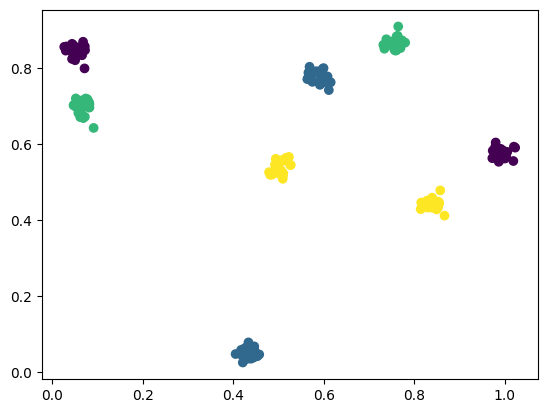

In [6]:
X, y = criaDatasetDificil()
plotDataset(X, y)
plt.show()

# Dividir em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [45]:
# Configurações do MLP
hidden_layer_sizes = [10, 5]
activation = 'relu'
learning_rate = 0.01
max_iter = 2000
random_state = 42

my_mlp, sk_mlp = treina_modelos(hidden_layer_sizes,activation,learning_rate,max_iter,random_state)

### Resultados

Na célula acima, executamos o `Nosso MLP` e o `MLPClassifier` do `sklearn`  com os mesmos dados e parametros de entrada, de forma que, a comparação seja justa.

> Os demais comportamentos não parametrizados neste experimento seguem em seus comportamentos padrões

MLP - Acurácia no treino: 0.4125
MLP - Acurácia no teste: 0.25

Scikit-Learn MLP - Acurácia no treino: 1.0
Scikit-Learn MLP - Acurácia no teste: 1.0


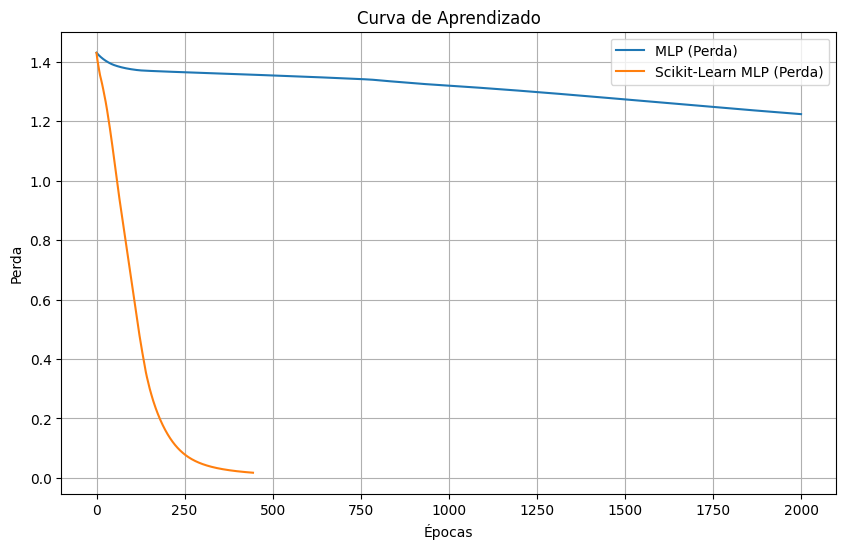

In [46]:
compara(my_mlp,sk_mlp)

O grafico acima apresenta a curva de aprendizado, demonstrando a redução do custo (loss) em relação as épocas.

Podemos observar que o `MLPClassifier` do `Scikit-learn` apresentou uma convergencia muito rápida e realizou um `early-stop` antes de alcançar 500 épocas. Já a nossa implementação teve uma redução muito sutil, mesmo depois de 2000 épocas.

Desta forma, é notável que nossa implementação não é tão eficiente quanto a versão fornecida pela biblioteca

0.25


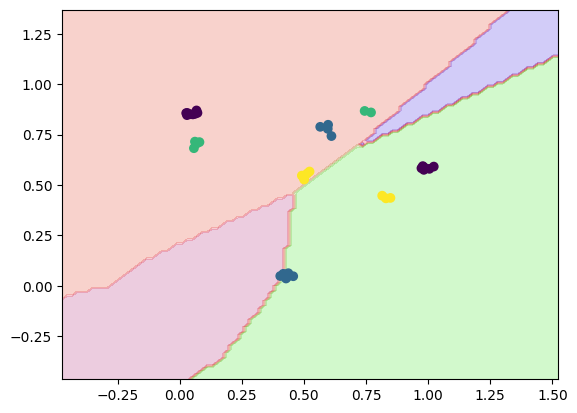

In [42]:
show_predic(my_mlp, X_test, y_test)

Acima temos o resultado da predição realizada pelo modelo treinado pelo MLP desenvolvido, com acurácia de apenas 0.25

1.0


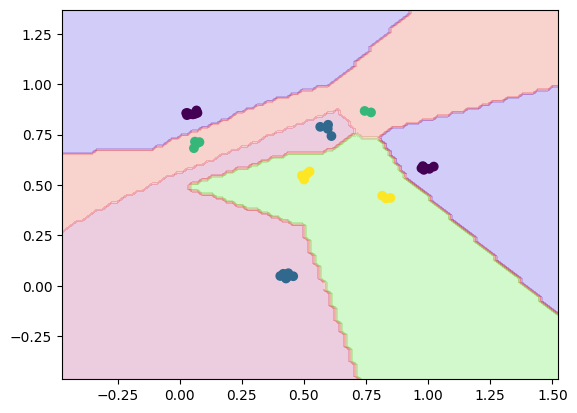

In [43]:
show_predic(sk_mlp, X_test, y_test)

Acima temos o resultado da predição realizada pelo MLP do scikit-learn, apresentando acurácia perfeita de 1.0, para este experimento